Resources for analysis:

* https://ucdavis-bioinformatics-training.github.io/2022-June-RNA-Seq-Analysis/data_analysis/DE_Analysis_mm_with_quizzes_fixed
* https://ucdavis-bioinformatics-training.github.io/2022-June-RNA-Seq-Analysis/data_reduction/03-counts_mm
* https://github.com/ben-laufer/RNA-seq/blob/main/04-limma-voom.R
* https://raw.githubusercontent.com/ucdavis-bioinformatics-training/2020-mRNA_Seq_Workshop/master/data_analysis/enrichment_mm.Rmd

## Generate Gene Counts

To generate gene counts:

```
for sample in $(cat samples.yml | grep -oP '\b\w+\b'); do
    echo ${sample}
    cat 03_bam_files/${sample}_ReadsPerGene.out.tab | tail -n +5 | cut -f4 > 05_gene_counts/${sample}.count
done
```

To extract gene IDs (because all of the files are sorted in the exact same order (by gene ID), we can just use the columns from any of the files):

```
tail -n +5 03_bam_files/G1_1_1_4_ReadsPerGene.out.tab | cut -f1 > 05_gene_counts/geneids.txt
```

Now, we want to combine all of these columns together and put it in a temporary file:

```
paste 05_gene_counts/geneids.txt 05_gene_counts/*.count > 05_gene_counts/tmp.out
```

And now, we label the columns with the sample IDs:

```
cat <(ls 05_gene_counts/*.count | sed 's/05_gene_counts\///;s/.count$//' | sort | paste -s) 05_gene_counts/tmp.out > 05_gene_counts/gene_counts.txt
rm 05_gene_counts/tmp.out
```

## Set Library Path

In [1]:
.libPaths("/share/korflab/home/viki/anaconda3/jupyter_nb/lib/R/library")

## Install Packages

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("edgeR")

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("rtracklayer")

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("XML")

## Load Libraries

In [3]:
library(edgeR)
library(rtracklayer)
library(gplots)
library(RColorBrewer)
library(dplyr)

# Sex Combined DEG Analysis

## Read in Counts and Create DEG List

In [12]:
counts <- read.delim("05_gene_counts/gene_counts.txt", row.names = 1)
head(counts)

,G1_1_1_4,G1_1_1_5,G1_1_1_6,G1_1_1_7,G1_1_2_4,G1_1_2_5,G1_1_2_6,G2_2_6_5,G2_2_6_6,G2_2_6_7,G2_2_6_8,G2_2_7_10,G2_2_7_11,G2_2_7_7,G2_2_7_8,G2_2_7_9
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102628,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
ENSMUSG00000100595,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000097426,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000086053,0,0,0,0,1,0,0,0,0,2,0,1,2,1,0,0


In [13]:
# Create DEG list
d0 <- DGEList(counts)

In [14]:
# Read in annotation
gtf_file <- "01_raw_data/mmEnsemble107/Mus_musculus_Ensemble_107_new.gtf.gz"
anno <- readGFF(gtf_file)

# Display dimensions of annotation
dim(anno)

# View annotation
head(anno)

[1] 1902015      26

,seqid,source,type,start,end,score,strand,phase,gene_id,gene_version,⋯,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,ccds_id,protein_id,protein_version
,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,havana,gene,150956201,150958296,NA,+,NA,ENSMUSG00000102628,2,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1,havana,transcript,150956201,150958296,NA,+,NA,ENSMUSG00000102628,2,⋯,havana,TEC,basic,NA (assigned to previous version 1),NA,NA,NA,NA,NA,NA
3,1,havana,exon,150956201,150958296,NA,+,NA,ENSMUSG00000102628,2,⋯,havana,TEC,basic,NA (assigned to previous version 1),1,ENSMUSE00001342333,2,NA,NA,NA
4,1,havana,gene,150983666,150984611,NA,+,NA,ENSMUSG00000100595,2,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,1,havana,transcript,150983666,150984611,NA,+,NA,ENSMUSG00000100595,2,⋯,havana,processed_pseudogene,basic,NA (assigned to previous version 1),NA,NA,NA,NA,NA,NA
6,1,havana,exon,150983666,150984611,NA,+,NA,ENSMUSG00000100595,2,⋯,havana,processed_pseudogene,basic,NA (assigned to previous version 1),1,ENSMUSE00001324949,2,NA,NA,NA


In [15]:
# Derive experiment metadata from sample names
sample_names <- colnames(counts)

# Derive experiment metadata
metadata <- as.data.frame(do.call(rbind, strsplit(sample_names, '[_]', perl=TRUE)))
colnames(metadata) <- c('treatment', 'treatment_group', 'dam', 'pup')

# Convert treatment levels
metadata <- metadata %>%
  mutate(treatment = ifelse(treatment == "G1", "Control", 
                            ifelse(treatment == "G2", "FAexcess", treatment)))

# Set row names based on original sample names
rownames(metadata) <- sample_names

# Add sample sex
metadata$sex <- c("Female", "Female", "Male", "Male", "Male", "Female", "Female", "Female", "Female", "Female", "Female", "Female", "Male", "Male", "Male", "Female")

# Print the resulting metadata
print(metadata)

          treatment treatment_group dam pup    sex
G1_1_1_4    Control               1   1   4 Female
G1_1_1_5    Control               1   1   5 Female
G1_1_1_6    Control               1   1   6   Male
G1_1_1_7    Control               1   1   7   Male
G1_1_2_4    Control               1   2   4   Male
G1_1_2_5    Control               1   2   5 Female
G1_1_2_6    Control               1   2   6 Female
G2_2_6_5   FAexcess               2   6   5 Female
G2_2_6_6   FAexcess               2   6   6 Female
G2_2_6_7   FAexcess               2   6   7 Female
G2_2_6_8   FAexcess               2   6   8 Female
G2_2_7_10  FAexcess               2   7  10 Female
G2_2_7_11  FAexcess               2   7  11   Male
G2_2_7_7   FAexcess               2   7   7   Male
G2_2_7_8   FAexcess               2   7   8   Male
G2_2_7_9   FAexcess               2   7   9 Female


In [16]:
# Create groups
metadata$group <- interaction(metadata$treatment)
table(metadata$group)


 Control FAexcess 
       7        9 

## Preprocess and Normalize

In [17]:
d0 <- calcNormFactors(d0)
d0$samples

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
G1_1_1_4,1,12300720,0.9936017
G1_1_1_5,1,10909151,0.9836129
G1_1_1_6,1,13508769,0.9758412
G1_1_1_7,1,15557657,0.9423234
G1_1_2_4,1,9354623,0.9903152
G1_1_2_5,1,15495778,0.8499332
G1_1_2_6,1,13763281,0.9829010
G2_2_6_5,1,13304554,1.0070883
G2_2_6_6,1,9568818,1.0721004


## Filter Genes

In [18]:
# Create design matrix
group <- metadata$group
sex <- as.factor(metadata$sex)

mm <- model.matrix(~0 + group + sex)
head(mm)

,groupControl,groupFAexcess,sexMale
1,1,0,0
2,1,0,0
3,1,0,1
4,1,0,1
5,1,0,1
6,1,0,0


In [19]:
# Filter genes by expression
keep <- filterByExpr(d0, mm)

# View number of genes retained
sum(keep)

[1] 17279

In [20]:
d <- d0[keep,]

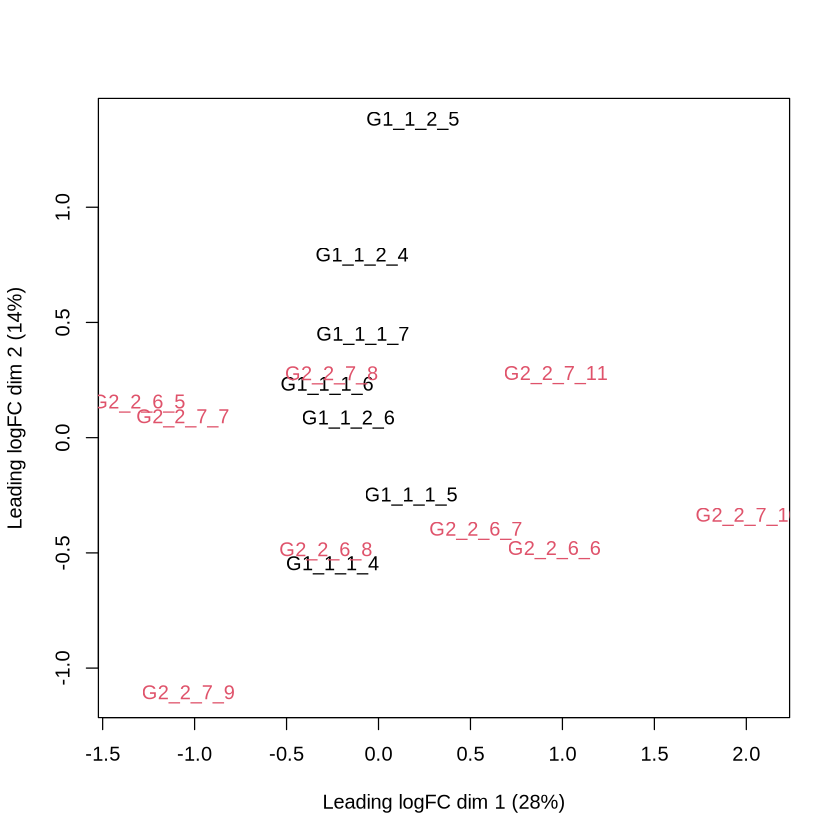

In [21]:
# Visualize data with multidimensional scaling plot
plotMDS(d, col = as.numeric(metadata$group), cex=1)

In [22]:
# Obtain log-transformed normalized expression data
logcpm <- cpm(d, prior.count=2, log=TRUE)
write.table(logcpm,"05_gene_counts/normalized_counts.txt",sep="\t",quote=F)

## Voom Transform and Calculate Variance Weights

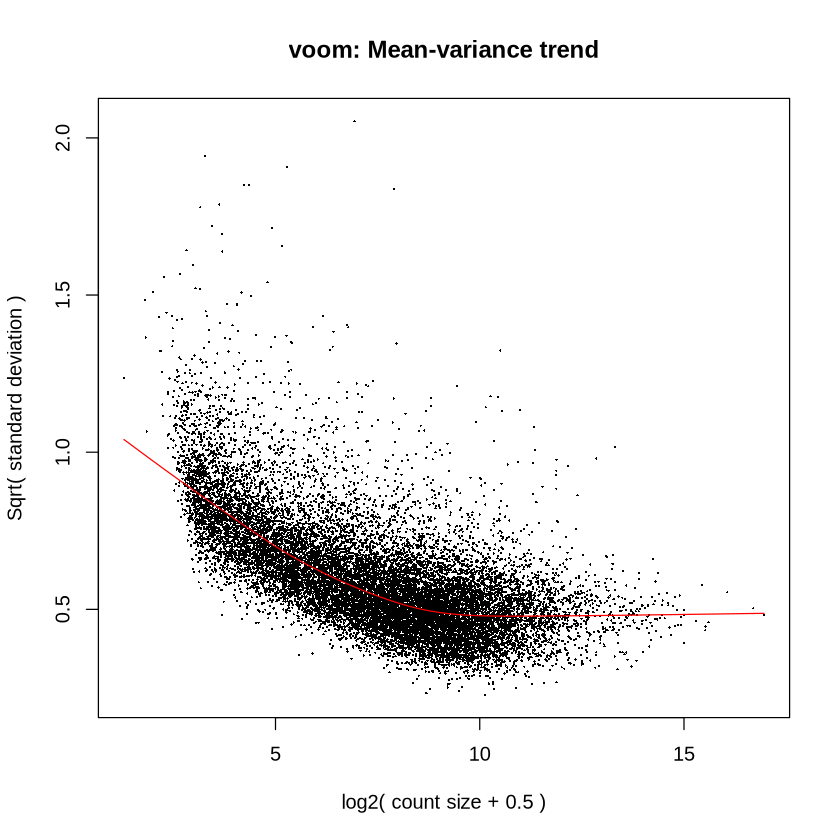

In [23]:
# Voom transformation
y <- voom(d, mm, plot = T)

## Fit Linear Model in Limma

In [24]:
# Fit linear model
fit <- lmFit(y, mm)

head(coef(fit))

,groupControl,groupFAexcess,sexMale
ENSMUSG00000051285,5.7397673,5.7689473,0.0009298765
ENSMUSG00000103509,-1.2781395,-0.5527627,-0.4714995013
ENSMUSG00000097797,0.7523235,0.3128296,-0.0396430730
ENSMUSG00000026312,3.7580010,3.9046875,-0.2368618389
ENSMUSG00000039748,0.8716317,1.0144287,-0.0144202819
ENSMUSG00000057363,5.0764878,4.5203876,-0.1853905496


## DEG Analysis

In [25]:
contr <- makeContrasts(groupFAexcess - groupControl, levels = colnames(coef(fit)))
print(contr)

# Estimate contrast for each gene
tmp <- contrasts.fit(fit, contr)

# Apply EBayes
tmp <- eBayes(tmp)

# Multiple testing adjustment
top.table <- topTable(tmp, adjust.method = "BH", sort.by = "P", n = Inf)

# How many DEGs are there after FDR correction
length(which(top.table$adj.P.Val < 0.05))

# View top 50 DEGs
head(top.table, 50)

# Save top.table as a CSV file
write.csv(top.table, file = "05_DEGs/faexcess_vs_control_results.csv", row.names = TRUE)

# Visualize Volcano Plot
pdf("05_DEGs/volcanoplot_faexcess_vs_control.pdf")
volcanoplot(tmp, coef=1, highlight=8, names=rownames(tmp), main="Control vs. FAexcess", cex.main = 0.8)
dev.off()

# Visualize Heatmap
pdf("05_DEGs/heatmap_faexcess_vs_control.pdf", height = 15, width = 10)
heatmap.2(
  logcpm[rownames(top.table), ],
  col = brewer.pal(11, "RdBu"),
  scale = "row",
  trace = "none",
  cexCol = 0.9  
)
dev.off()

               Contrasts
Levels          groupFAexcess - groupControl
  groupControl                            -1
  groupFAexcess                            1
  sexMale                                  0


[1] 647

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000058886,-0.5787290,7.0085623,-7.111117,1.095052e-06,0.01519353,5.740680
ENSMUSG00000030403,0.5813029,5.1052222,6.668602,2.610049e-06,0.01519353,4.899903
ENSMUSG00002075524,-2.7873593,0.1724406,-6.453413,4.020050e-06,0.01519353,2.856818
ENSMUSG00000019763,0.7084379,3.6195849,6.396114,4.514747e-06,0.01519353,4.264275
ENSMUSG00000043065,1.0115498,2.6927432,6.365215,4.807195e-06,0.01519353,4.012693
ENSMUSG00000027778,0.9707882,2.4679749,6.319534,5.275837e-06,0.01519353,3.872009
ENSMUSG00000020267,-0.6868905,9.7193142,-6.141215,7.605624e-06,0.01578489,3.899605
ENSMUSG00000118537,-0.9412231,3.6379626,-6.097171,8.330023e-06,0.01578489,3.747400
ENSMUSG00000028890,-0.5463247,6.6450933,-6.090276,8.449693e-06,0.01578489,3.798894


png 
  2

png 
  2

## Sex Stratified DEG Analysis

In [58]:
counts <- read.delim("05_gene_counts/gene_counts.txt", row.names = 1)
head(counts)

,G1_1_1_4,G1_1_1_5,G1_1_1_6,G1_1_1_7,G1_1_2_4,G1_1_2_5,G1_1_2_6,G2_2_6_5,G2_2_6_6,G2_2_6_7,G2_2_6_8,G2_2_7_10,G2_2_7_11,G2_2_7_7,G2_2_7_8,G2_2_7_9
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102628,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
ENSMUSG00000100595,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000097426,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000086053,0,0,0,0,1,0,0,0,0,2,0,1,2,1,0,0


In [59]:
# Create DEG list
d0 <- DGEList(counts)

In [60]:
# Read in annotation
gtf_file <- "01_raw_data/mmEnsemble107/Mus_musculus_Ensemble_107_new.gtf.gz"
anno <- readGFF(gtf_file)

# Display dimensions of annotation
dim(anno)

# View annotation
head(anno)

[1] 1902015      26

,seqid,source,type,start,end,score,strand,phase,gene_id,gene_version,⋯,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,ccds_id,protein_id,protein_version
,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,havana,gene,150956201,150958296,NA,+,NA,ENSMUSG00000102628,2,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1,havana,transcript,150956201,150958296,NA,+,NA,ENSMUSG00000102628,2,⋯,havana,TEC,basic,NA (assigned to previous version 1),NA,NA,NA,NA,NA,NA
3,1,havana,exon,150956201,150958296,NA,+,NA,ENSMUSG00000102628,2,⋯,havana,TEC,basic,NA (assigned to previous version 1),1,ENSMUSE00001342333,2,NA,NA,NA
4,1,havana,gene,150983666,150984611,NA,+,NA,ENSMUSG00000100595,2,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,1,havana,transcript,150983666,150984611,NA,+,NA,ENSMUSG00000100595,2,⋯,havana,processed_pseudogene,basic,NA (assigned to previous version 1),NA,NA,NA,NA,NA,NA
6,1,havana,exon,150983666,150984611,NA,+,NA,ENSMUSG00000100595,2,⋯,havana,processed_pseudogene,basic,NA (assigned to previous version 1),1,ENSMUSE00001324949,2,NA,NA,NA


In [61]:
# Derive experiment metadata from sample names
sample_names <- colnames(counts)

# Derive experiment metadata
metadata <- as.data.frame(do.call(rbind, strsplit(sample_names, '[_]', perl=TRUE)))
colnames(metadata) <- c('treatment', 'treatment_group', 'dam', 'pup')

# Convert treatment levels
metadata <- metadata %>%
  mutate(treatment = ifelse(treatment == "G1", "Control", 
                            ifelse(treatment == "G2", "FAexcess", treatment)))

# Set row names based on original sample names
rownames(metadata) <- sample_names

# Add sample sex
metadata$sex <- c("Female", "Female", "Male", "Male", "Male", "Female", "Female", "Female", "Female", "Female", "Female", "Female", "Male", "Male", "Male", "Female")

# Print the resulting metadata
print(metadata)

          treatment treatment_group dam pup    sex
G1_1_1_4    Control               1   1   4 Female
G1_1_1_5    Control               1   1   5 Female
G1_1_1_6    Control               1   1   6   Male
G1_1_1_7    Control               1   1   7   Male
G1_1_2_4    Control               1   2   4   Male
G1_1_2_5    Control               1   2   5 Female
G1_1_2_6    Control               1   2   6 Female
G2_2_6_5   FAexcess               2   6   5 Female
G2_2_6_6   FAexcess               2   6   6 Female
G2_2_6_7   FAexcess               2   6   7 Female
G2_2_6_8   FAexcess               2   6   8 Female
G2_2_7_10  FAexcess               2   7  10 Female
G2_2_7_11  FAexcess               2   7  11   Male
G2_2_7_7   FAexcess               2   7   7   Male
G2_2_7_8   FAexcess               2   7   8   Male
G2_2_7_9   FAexcess               2   7   9 Female


In [62]:
# Create groups
metadata$group <- interaction(metadata$treatment, metadata$sex)
table(metadata$group)


 Control.Female FAexcess.Female    Control.Male   FAexcess.Male 
              4               6               3               3 

## Preprocess and Normalize

In [63]:
d0 <- calcNormFactors(d0)
d0$samples

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
G1_1_1_4,1,12300720,0.9936017
G1_1_1_5,1,10909151,0.9836129
G1_1_1_6,1,13508769,0.9758412
G1_1_1_7,1,15557657,0.9423234
G1_1_2_4,1,9354623,0.9903152
G1_1_2_5,1,15495778,0.8499332
G1_1_2_6,1,13763281,0.9829010
G2_2_6_5,1,13304554,1.0070883
G2_2_6_6,1,9568818,1.0721004


In [64]:
# Create design matrix
group <- metadata$group
mm <- model.matrix(~0 + group)
head(mm)

,groupControl.Female,groupFAexcess.Female,groupControl.Male,groupFAexcess.Male
1,1,0,0,0
2,1,0,0,0
3,0,0,1,0
4,0,0,1,0
5,0,0,1,0
6,1,0,0,0


In [65]:
# Filter genes by expression
keep <- filterByExpr(d0, mm)

# View number of genes retained
sum(keep) 

[1] 17862

In [66]:
d <- d0[keep,]

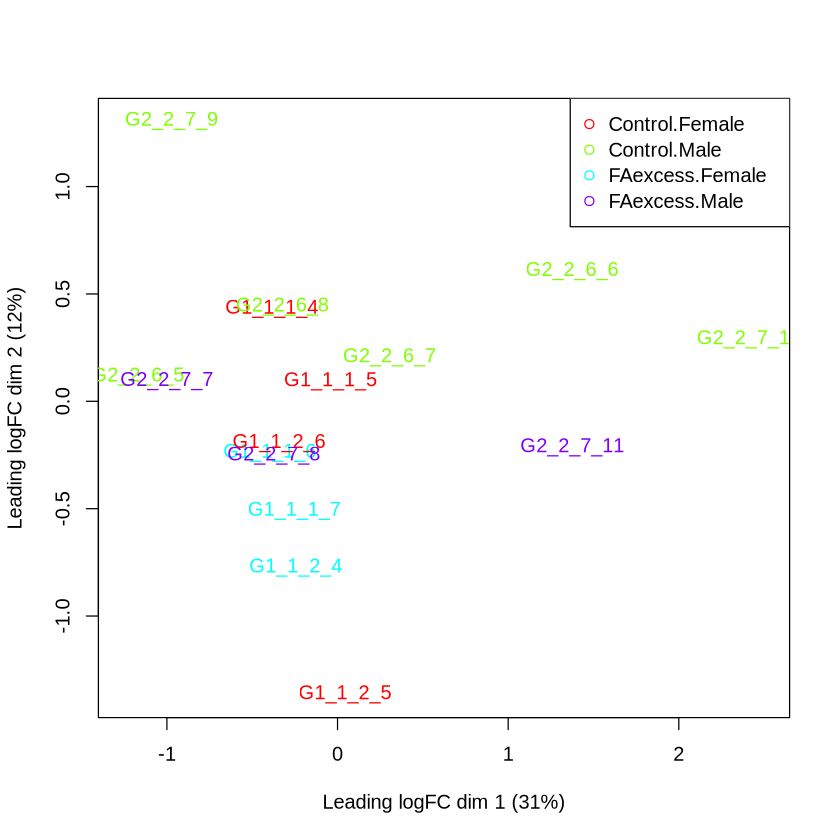

In [67]:
# Define unique groups and corresponding colors
groups <- unique(metadata$group)
colors <- rainbow(length(groups))

# Map colors to groups
group_colors <- setNames(colors, groups)

# Visualize data with multidimensional scaling plot
plotMDS(d, col = group_colors[metadata$group], cex=1)

# Add legend
legend("topright", legend = groups, col = colors, pch = 1, cex = 1)

In [68]:
# Obtain log-transformed normalized expression data
logcpm <- cpm(d, prior.count=2, log=TRUE)
write.table(logcpm,"05_gene_counts/sex_stratified_normalized_counts.txt",sep="\t",quote=F)

## Voom Transform and Calculate Variance Weights

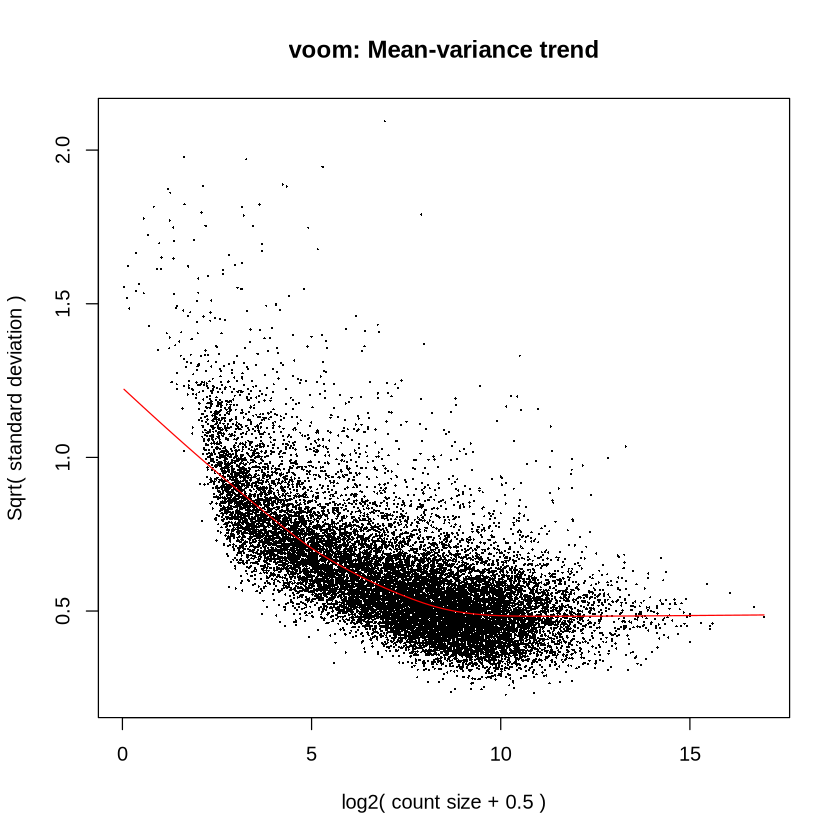

In [69]:
# Voom transformation
y <- voom(d, mm, plot = T)

## Fit Linear Model in Limma

In [70]:
# Fit linear model
fit <- lmFit(y, mm)

head(coef(fit))

,groupControl.Female,groupFAexcess.Female,groupControl.Male,groupFAexcess.Male
ENSMUSG00000051285,5.7008444,5.7948592,5.7928280,5.7165064
ENSMUSG00000103509,-1.5944501,-0.3767355,-1.2635969,-1.4581499
ENSMUSG00000097797,0.8824385,0.2077341,0.5401060,0.5020416
ENSMUSG00000026312,3.6851302,3.9513246,3.6272551,3.5601872
ENSMUSG00000039748,0.8096522,1.0550842,0.9400093,0.9146627
ENSMUSG00000057363,5.1224601,4.4846058,4.8260252,4.4156413


## DEG Analysis

In [71]:
# Determine pairwise combinations for analysis
groups <- levels(metadata$group)
pairwise_combinations <- combn(groups, 2, simplify = TRUE)
print(pairwise_combinations)

# FLip so condition comes before control
pairwise_combinations <- apply(pairwise_combinations, 2, rev)

# Switch exception
pairwise_combinations[1, 4] <- "FAexcess.Female"
pairwise_combinations[2, 4] <- "Control.Male"

print(pairwise_combinations)

     [,1]              [,2]             [,3]             [,4]             
[1,] "Control.Female"  "Control.Female" "Control.Female" "FAexcess.Female"
[2,] "FAexcess.Female" "Control.Male"   "FAexcess.Male"  "Control.Male"   
     [,5]              [,6]           
[1,] "FAexcess.Female" "Control.Male" 
[2,] "FAexcess.Male"   "FAexcess.Male"
     [,1]              [,2]             [,3]             [,4]             
[1,] "FAexcess.Female" "Control.Male"   "FAexcess.Male"  "FAexcess.Female"
[2,] "Control.Female"  "Control.Female" "Control.Female" "Control.Male"   
     [,5]              [,6]           
[1,] "FAexcess.Male"   "FAexcess.Male"
[2,] "FAexcess.Female" "Control.Male" 


In [72]:
# Loop over each pairwise combination
for (i in 1:ncol(pairwise_combinations)) {
  # Extract the pair
  group1 <- pairwise_combinations[1, i]
  group2 <- pairwise_combinations[2, i]
  
  # Create contrast names that match the coefficients
  group1_col <- paste0("group", group1)
  group2_col <- paste0("group", group2)
  
  # Print for debugging
  cat("Processing:", group1, "vs", group2, "\n")
  cat("Contrast columns:", group1_col, "-", group2_col, "\n")
  
  # Define contrast
  contr <- makeContrasts(contrasts = paste0(group1_col, "-", group2_col), levels = colnames(coef(fit)))
  
  # Check contrast definition
  print(contr)
  
  # Estimate contrast for each gene
  tmp <- contrasts.fit(fit, contr)
  
  # Apply eBayes
  tmp <- eBayes(tmp)
  
  # Multiple testing adjustment
  top.table <- topTable(tmp, adjust.method = "BH", sort.by = "P", n = Inf)
  
  # Rename
  original_names <- c("Control.Female", "FAexcess.Female", "Control.Male", "FAexcess.Male")
  new_names <- c("control_female", "faexcess_female", "control_male", "faexcess_male")
  if (group1 %in% original_names) {
    group1 <- new_names[which(original_names == group1)]
  }
  if (group2 %in% original_names) {
    group2 <- new_names[which(original_names == group2)]
  }
    
  # Print or save the number of DEGs
  num_degs <- length(which(top.table$adj.P.Val < 0.05))
  cat("Comparison:", group1, "vs", group2, "- DEGs:", num_degs, "\n")
  
  # View the top 10 DEGs for each comparison
  print(head(top.table, 10))
  
  # Save the results
  write.csv(top.table, file = paste0("05_DEGs/", tolower(group1), "_vs_", tolower(group2), "_results.csv"), row.names = TRUE)
}

Processing: FAexcess.Female vs Control.Female 
Contrast columns: groupFAexcess.Female - groupControl.Female 
                      Contrasts
Levels                 groupFAexcess.Female-groupControl.Female
  groupControl.Female                                        -1
  groupFAexcess.Female                                        1
  groupControl.Male                                           0
  groupFAexcess.Male                                          0
Comparison: faexcess_female vs control_female - DEGs: 161 
                        logFC   AveExpr         t      P.Value  adj.P.Val
ENSMUSG00000085028  1.8189886 0.9664698  6.933464 2.185268e-06 0.03541077
ENSMUSG00000020722 -1.8351408 0.4267717 -6.476827 5.204264e-06 0.03541077
ENSMUSG00000045519 -1.0469321 4.8550325 -6.303640 7.286262e-06 0.03541077
ENSMUSG00000043065  1.1976760 2.6927432  6.004621 1.315074e-05 0.03541077
ENSMUSG00000025986  0.7265465 5.7662883  5.914425 1.575121e-05 0.03541077
ENSMUSG00000028890 -0.6499939 6.6450